In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"   #(xxxx is your specific GPU ID)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, GlobalAveragePooling2D
from MyEarlyStopping import MyEarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder  
import pandas as pd

In [3]:
All_data = ImageDataGenerator(preprocessing_function=preprocess_input)
All_data_generator = All_data.flow_from_directory('Mel_Audio_folder_digits',
                                                batch_size=1,
                                                target_size=(224,224),
                                                class_mode='categorical',
                                               shuffle=False)

Found 30000 images belonging to 10 classes.


In [4]:
image_names = All_data_generator.filenames
image_no = [i.split("/")[1].split("_")[2].split(".")[0] for i in image_names]
image_no = np.array(list(map(int, image_no)))
ALL_participant_class = [i.split("/")[1].split("_")[1] for i in image_names]
ALL_participant_class = np.array(list(map(int, ALL_participant_class)))
command_class = All_data_generator.classes
All_participant_class = tf.keras.utils.to_categorical(ALL_participant_class-1, num_classes=60)
All_command_class = tf.keras.utils.to_categorical(command_class, num_classes=10)
All_command_uniform = All_command_class*0+1/10

In [5]:
All_Inputs = [next(All_data_generator)[0][0] for _ in range(len(All_data_generator))]
All_Inputs = np.array(All_Inputs)

# performance of initial model 

In [6]:
Existing_Train_participant_class = np.load("Existing_Train_participant_class.npy")
Existing_Train_participant_uniform = np.load("Existing_Train_participant_uniform.npy")
Existing_Train_command_class = np.load("Existing_Train_command_class.npy")
Existing_Train_command_uniform = np.load("Existing_Train_command_uniform.npy")
Existing_Train_Inputs = np.load("Existing_Train_Inputs.npy")
Existing_Test_participant_class = np.load("Existing_Test_participant_class.npy")
Existing_Test_participant_uniform = np.load("Existing_Test_participant_uniform.npy")
Existing_Test_command_class = np.load("Existing_Test_command_class.npy")
Existing_Test_command_uniform = np.load("Existing_Test_command_uniform.npy")
Existing_Test_Inputs = np.load("Existing_Test_Inputs.npy")


speaker_number = Existing_Train_participant_class.shape[1]
speaker_number

18

In [7]:
# load the initial model 
resnet_model_0 = tf.keras.models.load_model('resnet_model_0531_digit_refine_group_5->30_final_free&unfree.h5')

In [8]:
# command_accuracy = []
# subject_accuracy = []
# for i in range(1,61):
    
#     select_indexs_test_i = (image_no>39)&(image_no<=49)&(ALL_participant_class==i)
#     Test_Inputs_i = All_Inputs[select_indexs_test_i]
#     Test_command_class_i = All_command_class[select_indexs_test_i]
#     Test_command_uniform_i = Test_command_class_i*0+1/10
    
#     # subject prediction 
#     predictions = resnet_model_0.predict(Test_Inputs_i)[0]
#     predicted_classes = np.argmax(predictions, axis=1)
#     true_classes = np.array([j.split("/")[1].split("_")[1] for j in All_data_generator.filenames])
#     true_classes = np.array(list(map(int, true_classes)))[select_indexs_test_i]-1
    
#     subject_accuracy.append(round(sum(x == y for x, y in zip(true_classes, predicted_classes)) / len(true_classes),4))
    
#     # command prediction 
#     predictions = resnet_model_0.predict(Test_Inputs_i)[1]
#     predicted_classes = np.argmax(predictions, axis=1)
#     true_classes = np.array([j.split("/")[0] for j in All_data_generator.filenames])
#     true_classes = np.array(list(map(int, true_classes)))[select_indexs_test_i]
    
#     command_accuracy.append(round(sum(x == y for x, y in zip(true_classes, predicted_classes)) / len(true_classes),4))


In [9]:
# performance_command = pd.DataFrame(columns=["Subject_No","add_data"] + list(range(1,61)))
# performance_speaker = pd.DataFrame(columns=["Subject_No","add_data"] + list(range(1,61)))
# performance_command = performance_command.append({"Subject_No":5,"add_data":"40%"}, ignore_index=True)
# performance_speaker = performance_speaker.append({"Subject_No":5,"add_data":"40%"}, ignore_index=True)
# performance_command.iloc[performance_command['Subject_No']==5,2:] = command_accuracy
# performance_speaker.iloc[performance_speaker['Subject_No']==5,2:] = subject_accuracy

performance_speaker = pd.read_csv("performance_speaker_0531_5->30_final_free&unfree.csv")
performance_command = pd.read_csv("performance_command_0531_5->30_final_free&unfree.csv")



# refine models

In [12]:
actv_fun_1_1 = "relu" 
actv_fun_1_2 = "sigmoid"
shape_1_1 = 128
shape_1_2 = 256
actv_fun_2_1 = "sigmoid" 
actv_fun_2_2 = "sigmoid"
shape_2_1 = 512
shape_2_2 = 512


In [13]:
# new_speaker = 6
add_data = 5 # 10%-->5; 20%-->10; 30%--> 15; 40% -->20;

for new_speaker in range(speaker_number+1,31):
    
    ####################################################################################################################
    # training 
    new_select_indexs = (image_no<=add_data-1)&(ALL_participant_class==new_speaker)
    new_Train_Inputs = All_Inputs[new_select_indexs]
    new_Train_participant_class = All_participant_class[new_select_indexs][:,0:new_speaker]
    new_Train_participant_uniform = new_Train_participant_class*0+1/new_speaker
    new_Train_command_class = All_command_class[new_select_indexs]
    new_Train_command_uniform = new_Train_command_class*0+1/10

    # testing
    new_select_indexs_test = (image_no>39)&(image_no<=49)&(ALL_participant_class==new_speaker)
    new_Test_Inputs = All_Inputs[new_select_indexs_test]
    new_Test_participant_class = All_participant_class[new_select_indexs_test][:,0:new_speaker]
    new_Test_participant_uniform = new_Test_participant_class*0+1/new_speaker
    new_Test_command_class = All_command_class[new_select_indexs_test]
    new_Test_command_uniform = new_Test_command_class*0+1/10

    # combine training
    update_Train_participant_class = np.vstack((np.hstack((Existing_Train_participant_class,np.zeros([len(Existing_Train_participant_class),1]))),new_Train_participant_class))
    update_Train_participant_uniform = update_Train_participant_class*0+1/new_speaker
    update_Train_command_class = np.vstack((Existing_Train_command_class,new_Train_command_class))
    update_Train_command_uniform = update_Train_command_class*0+1/10
    update_Train_Inputs = np.vstack((Existing_Train_Inputs,new_Train_Inputs))

    # combine testing
    update_Test_participant_class = np.vstack((np.hstack((Existing_Test_participant_class,np.zeros([len(Existing_Test_participant_class),1]))),new_Test_participant_class))
    update_Test_participant_uniform = update_Test_participant_class*0+1/new_speaker
    update_Test_command_class = np.vstack((Existing_Test_command_class,new_Test_command_class))
    update_Test_command_uniform = update_Test_command_class*0+1/10
    update_Test_Inputs = np.vstack((Existing_Test_Inputs,new_Test_Inputs))
    

    ####################################################################################################################
    ### feature extraction layers
    resnet_model = Model(resnet_model_0.input, resnet_model_0.layers[174].output)

    d = resnet_model.output.shape[-1] # dimension of last layer

    ###################### model 1 ###################### 
#      # chenge the weights in speaker task to initial weights
#     initializer = tf.keras.initializers.GlorotUniform()
#     w1 = initializer(shape=resnet_model.get_layer(name = "weight_1").get_weights()[0].shape)
#     initializer = tf.keras.initializers.Zeros()
#     w2 = initializer(shape=resnet_model.get_layer(name = "weight_1").get_weights()[1].shape)
#     resnet_model.get_layer(name = "weight_1").set_weights([w1,w2])
    
    layer_1_0 = tf.keras.layers.Dense(d,name="weight_1")(resnet_model.output) #times weight before flatten
    layer_1_1 = tf.keras.layers.Flatten(name='flatten_1')(layer_1_0)

    Dense_1_1 = tf.keras.layers.Dense(shape_1_1, activation = actv_fun_1_1,name='fc1_1')
    layer_1_2 = Dense_1_1(layer_1_1)
    Dense_1_2 = tf.keras.layers.Dense(shape_1_2, activation = actv_fun_1_2,name='fc1_2')
    layer_1_3 = Dense_1_2(layer_1_2)

    Dense_1_3 = tf.keras.layers.Dense(new_speaker, activation='softmax' ,name='participant_output')
    out_layer_1 = Dense_1_3(layer_1_3)

    ###################### model 2 ###################### 
    w1 = tf.constant_initializer(resnet_model_0.get_layer(name = "weight_2").get_weights()[0])
    w2 = tf.constant_initializer(resnet_model_0.get_layer(name = "weight_2").get_weights()[1])
    layer_2_0 = tf.keras.layers.Dense(d,name="weight_2",kernel_initializer = w1 ,bias_initializer = w2)(resnet_model.output) #times weight before flatten

    layer_2_1 = tf.keras.layers.Flatten(name='flatten_2')(layer_2_0)

    w1 = tf.constant_initializer(resnet_model_0.get_layer(name = "fc2_1").get_weights()[0])
    w2 = tf.constant_initializer(resnet_model_0.get_layer(name = "fc2_1").get_weights()[1])
    Dense_2_1 = tf.keras.layers.Dense(shape_2_1, activation=actv_fun_2_1,kernel_initializer = w1 ,bias_initializer = w2,name='fc2_1')
    layer_2_2  = Dense_2_1(layer_2_1)

    w1 = tf.constant_initializer(resnet_model_0.get_layer(name = "fc2_2").get_weights()[0])
    w2 = tf.constant_initializer(resnet_model_0.get_layer(name = "fc2_2").get_weights()[1])
    Dense_2_2 = tf.keras.layers.Dense(shape_2_2, activation=actv_fun_2_2,kernel_initializer = w1 ,bias_initializer = w2, name='fc2_2')
    layer_2_3  = Dense_2_2(layer_2_2)

    w1 = tf.constant_initializer(resnet_model_0.get_layer(name = "command_output").get_weights()[0])
    w2 = tf.constant_initializer(resnet_model_0.get_layer(name = "command_output").get_weights()[1])
    Dense_2_3 = tf.keras.layers.Dense(10, activation='softmax',kernel_initializer = w1 ,bias_initializer = w2,name='command_output')
    out_layer_2 = Dense_2_3(layer_2_3)

    ###################### model 1' ###################### 
    layer_1_2_  = Dense_2_1(layer_1_1)
    layer_1_3_  = Dense_2_2(layer_1_2_)
    out_layer_1_ = Dense_2_3(layer_1_3_)

    ###################### model 1' ###################### 
    layer_2_2_  = Dense_1_1(layer_2_1)
    layer_2_3_  = Dense_1_2(layer_2_2_)
    out_layer_2_ = Dense_1_3(layer_2_3_)

    resnet_model = tf.keras.Model(resnet_model.input, [out_layer_1,out_layer_2,out_layer_1_,out_layer_2_])

    # resnet_model.summary() 

    w_1, w_2, w_1_, w_2_ = 1,1,1,1
    ##################### training ############################
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    callbacks = [MyEarlyStopping(monitor1 = resnet_model.layers[-1].name+'_accuracy',
                                  monitor2 = resnet_model.layers[-2].name+'_accuracy',
                                  patience=10,restore_best_weights=True)]
    resnet_model.compile(optimizer=opt, loss=["categorical_crossentropy","categorical_crossentropy","mse","mse"],
                         loss_weights=[w_1, w_2, w_1_, w_2_], metrics=['accuracy'])
    
    for layer in resnet_model.layers[0:175]:
        layer.trainable = False
    history = resnet_model.fit(update_Train_Inputs, 
                               {resnet_model.layers[-2].name:update_Train_participant_class, 
                                resnet_model.layers[-1].name:update_Train_command_class,
                                resnet_model.layers[-1].name+"_1":update_Train_command_uniform, 
                                resnet_model.layers[-2].name+"_1":update_Train_participant_uniform}, 
                               callbacks=callbacks,
                               batch_size=64,
                               epochs=10)
    
    for layer in resnet_model.layers[0:175]:
        layer.trainable = True
    history = resnet_model.fit(update_Train_Inputs, 
                               {resnet_model.layers[-2].name:update_Train_participant_class, 
                                resnet_model.layers[-1].name:update_Train_command_class,
                                resnet_model.layers[-1].name+"_1":update_Train_command_uniform, 
                                resnet_model.layers[-2].name+"_1":update_Train_participant_uniform}, 
                               callbacks=callbacks,
                               batch_size=64,
                               epochs=10)

 
    
    resnet_model.save('resnet_model_0531_digit_refine_group_5->30_final_free&unfree.h5')
    ####################################################################################################################
    ####################################################################################################################

    subject_accuracy = []
    command_accuracy = []
    
    for i in range(1,61):

        select_indexs_test_i = (image_no>39)&(image_no<=49)&(ALL_participant_class==i)
        Test_Inputs_i = All_Inputs[select_indexs_test_i]
        Test_command_class_i = All_command_class[select_indexs_test_i]
        Test_command_uniform_i = Test_command_class_i*0+1/10

        # subject prediction 
        predictions = resnet_model.predict(Test_Inputs_i)[0]
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.array([j.split("/")[1].split("_")[1] for j in All_data_generator.filenames])
        true_classes = np.array(list(map(int, true_classes)))[select_indexs_test_i]-1

        subject_accuracy.append(round(sum(x == y for x, y in zip(true_classes, predicted_classes)) / len(true_classes),4))

        # command prediction 
        predictions = resnet_model.predict(Test_Inputs_i)[1]
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.array([j.split("/")[0] for j in All_data_generator.filenames])
        true_classes = np.array(list(map(int, true_classes)))[select_indexs_test_i]

        command_accuracy.append(round(sum(x == y for x, y in zip(true_classes, predicted_classes)) / len(true_classes),4))
    
    # store the performance 
    performance_command = performance_command.append({"Subject_No":new_speaker,"add_data":str(int(100*add_data/50))+"%"}, ignore_index=True)
    performance_speaker = performance_speaker.append({"Subject_No":new_speaker,"add_data":str(int(100*add_data/50))+"%"}, ignore_index=True)
    performance_command.iloc[performance_command['Subject_No']==new_speaker,2:] = command_accuracy
    performance_speaker.iloc[performance_speaker['Subject_No']==new_speaker,2:] = subject_accuracy
    
    
    resnet_model_0 = tf.keras.models.load_model('resnet_model_0531_digit_refine_group_5->30_final_free&unfree.h5')
    Existing_Train_participant_class = update_Train_participant_class 
    Existing_Train_participant_uniform =  update_Train_participant_uniform
    Existing_Train_command_class = update_Train_command_class 
    Existing_Train_command_uniform = update_Train_command_uniform 
    Existing_Train_Inputs = update_Train_Inputs
    Existing_Test_participant_class = update_Test_participant_class 
    Existing_Test_participant_uniform =  update_Test_participant_uniform
    Existing_Test_command_class = update_Test_command_class 
    Existing_Test_command_uniform = update_Test_command_uniform 
    Existing_Test_Inputs = update_Test_Inputs

Epoch 1/10
27/27 [==============================] - 7s 270ms/step - loss: 0.4481 - participant_output_loss: 0.4375 - command_output_loss: 0.0031 - command_output_1_loss: 0.0067 - participant_output_1_loss: 8.3122e-04 - participant_output_accuracy: 0.9424 - command_output_accuracy: 0.9988 - command_output_1_accuracy: 0.0841 - participant_output_1_accuracy: 0.0853
Epoch 2/10
27/27 [==============================] - 6s 229ms/step - loss: 0.0911 - participant_output_loss: 0.0870 - command_output_loss: 0.0013 - command_output_1_loss: 0.0025 - participant_output_1_loss: 3.2583e-04 - participant_output_accuracy: 0.9988 - command_output_accuracy: 0.9994 - command_output_1_accuracy: 0.1518 - participant_output_1_accuracy: 0.0700
Epoch 3/10
27/27 [==============================] - 7s 250ms/step - loss: 0.0580 - participant_output_loss: 0.0544 - command_output_loss: 0.0012 - command_output_1_loss: 0.0022 - participant_output_1_loss: 2.0527e-04 - participant_output_accuracy: 1.0000 - command_outpu

28/28 [==============================] - 7s 254ms/step - loss: 0.0653 - participant_output_loss: 0.0629 - command_output_loss: 3.5436e-04 - command_output_1_loss: 0.0021 - participant_output_1_loss: 7.3729e-05 - participant_output_accuracy: 0.9994 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.1434 - participant_output_1_accuracy: 0.0903
Epoch 4/10
28/28 [==============================] - 7s 252ms/step - loss: 0.0516 - participant_output_loss: 0.0494 - command_output_loss: 2.1744e-04 - command_output_1_loss: 0.0018 - participant_output_1_loss: 5.6991e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.1954 - participant_output_1_accuracy: 0.0954
Epoch 5/10
28/28 [==============================] - 7s 239ms/step - loss: 0.0427 - participant_output_loss: 0.0408 - command_output_loss: 1.6895e-04 - command_output_1_loss: 0.0017 - participant_output_1_loss: 5.0578e-05 - participant_output_accuracy: 1.0000 - command_outp

29/29 [==============================] - 7s 228ms/step - loss: 0.0577 - participant_output_loss: 0.0560 - command_output_loss: 2.9391e-04 - command_output_1_loss: 0.0014 - participant_output_1_loss: 4.7420e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0328 - participant_output_1_accuracy: 0.0217
Epoch 6/10
29/29 [==============================] - 6s 219ms/step - loss: 0.0627 - participant_output_loss: 0.0540 - command_output_loss: 0.0072 - command_output_1_loss: 0.0014 - participant_output_1_loss: 6.0479e-05 - participant_output_accuracy: 0.9989 - command_output_accuracy: 0.9983 - command_output_1_accuracy: 0.0672 - participant_output_1_accuracy: 0.0167
Epoch 7/10
29/29 [==============================] - 7s 230ms/step - loss: 0.0712 - participant_output_loss: 0.0603 - command_output_loss: 0.0095 - command_output_1_loss: 0.0014 - participant_output_1_loss: 9.1396e-05 - participant_output_accuracy: 0.9972 - command_output_accur

29/29 [==============================] - 7s 231ms/step - loss: 0.0323 - participant_output_loss: 0.0316 - command_output_loss: 1.1634e-04 - command_output_1_loss: 5.6269e-04 - participant_output_1_loss: 3.5158e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0222 - participant_output_1_accuracy: 0.0676
Epoch 8/10
29/29 [==============================] - 7s 241ms/step - loss: 0.0291 - participant_output_loss: 0.0285 - command_output_loss: 1.0273e-04 - command_output_1_loss: 5.1097e-04 - participant_output_1_loss: 3.0671e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0168 - participant_output_1_accuracy: 0.0627
Epoch 9/10
29/29 [==============================] - 7s 256ms/step - loss: 0.0263 - participant_output_loss: 0.0257 - command_output_loss: 9.3717e-05 - command_output_1_loss: 4.7114e-04 - participant_output_1_loss: 2.8100e-05 - participant_output_accuracy: 1.0000 - 

30/30 [==============================] - 7s 218ms/step - loss: 0.0281 - participant_output_loss: 0.0276 - command_output_loss: 8.0633e-05 - command_output_1_loss: 4.1245e-04 - participant_output_1_loss: 4.0755e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0711 - participant_output_1_accuracy: 0.0458
Epoch 10/10
30/30 [==============================] - 7s 221ms/step - loss: 0.0254 - participant_output_loss: 0.0250 - command_output_loss: 7.6171e-05 - command_output_1_loss: 3.4879e-04 - participant_output_1_loss: 3.8304e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0321 - participant_output_1_accuracy: 0.0421
Epoch 1/10
30/30 [==============================] - 7s 244ms/step - loss: 0.0232 - participant_output_loss: 0.0228 - command_output_loss: 7.2545e-05 - command_output_1_loss: 3.1075e-04 - participant_output_1_loss: 3.5529e-05 - participant_output_accuracy: 1.0000 -

31/31 [==============================] - 7s 241ms/step - loss: 0.0216 - participant_output_loss: 0.0214 - command_output_loss: 6.1222e-05 - command_output_1_loss: 1.5733e-04 - participant_output_1_loss: 2.7965e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0774 - participant_output_1_accuracy: 0.0287
Epoch 2/10
31/31 [==============================] - 8s 248ms/step - loss: 0.0200 - participant_output_loss: 0.0197 - command_output_loss: 5.7839e-05 - command_output_1_loss: 1.4316e-04 - participant_output_1_loss: 2.6132e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.1036 - participant_output_1_accuracy: 0.0267
Epoch 3/10
31/31 [==============================] - 8s 243ms/step - loss: 0.0185 - participant_output_loss: 0.0183 - command_output_loss: 5.4983e-05 - command_output_1_loss: 1.2880e-04 - participant_output_1_loss: 2.4899e-05 - participant_output_accuracy: 1.0000 - 

32/32 [==============================] - 8s 243ms/step - loss: 0.0211 - participant_output_loss: 0.0208 - command_output_loss: 1.0017e-04 - command_output_1_loss: 1.3657e-04 - participant_output_1_loss: 4.3470e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0375 - participant_output_1_accuracy: 0.0550
Epoch 4/10
32/32 [==============================] - 7s 230ms/step - loss: 0.0200 - participant_output_loss: 0.0197 - command_output_loss: 9.6419e-05 - command_output_1_loss: 1.2231e-04 - participant_output_1_loss: 4.1870e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0250 - participant_output_1_accuracy: 0.0525
Epoch 5/10
32/32 [==============================] - 7s 216ms/step - loss: 0.0184 - participant_output_loss: 0.0181 - command_output_loss: 8.4709e-05 - command_output_1_loss: 1.0600e-04 - participant_output_1_loss: 3.9150e-05 - participant_output_accuracy: 1.0000 - 

33/33 [==============================] - 8s 228ms/step - loss: 0.0435 - participant_output_loss: 0.0431 - command_output_loss: 8.5868e-05 - command_output_1_loss: 2.2329e-04 - participant_output_1_loss: 4.9754e-05 - participant_output_accuracy: 0.9976 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.0498 - participant_output_1_accuracy: 0.0380
Epoch 6/10
33/33 [==============================] - 8s 257ms/step - loss: 0.0730 - participant_output_loss: 0.0389 - command_output_loss: 0.0338 - command_output_1_loss: 2.9544e-04 - participant_output_1_loss: 5.8489e-05 - participant_output_accuracy: 0.9976 - command_output_accuracy: 0.9961 - command_output_1_accuracy: 0.1668 - participant_output_1_accuracy: 0.0249
Epoch 7/10
33/33 [==============================] - 8s 254ms/step - loss: 0.0599 - participant_output_loss: 0.0451 - command_output_loss: 0.0137 - command_output_1_loss: 9.6412e-04 - participant_output_1_loss: 1.3378e-04 - participant_output_accuracy: 0.9980 - command_

33/33 [==============================] - 7s 220ms/step - loss: 0.0184 - participant_output_loss: 0.0182 - command_output_loss: 3.5094e-05 - command_output_1_loss: 1.2822e-04 - participant_output_1_loss: 2.2173e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.1548 - participant_output_1_accuracy: 0.0176
Epoch 8/10
33/33 [==============================] - 7s 219ms/step - loss: 0.0173 - participant_output_loss: 0.0171 - command_output_loss: 3.3770e-05 - command_output_1_loss: 1.1352e-04 - participant_output_1_loss: 2.0990e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.1571 - participant_output_1_accuracy: 0.0205
Epoch 9/10
33/33 [==============================] - 7s 218ms/step - loss: 0.0163 - participant_output_loss: 0.0161 - command_output_loss: 3.2367e-05 - command_output_1_loss: 1.0009e-04 - participant_output_1_loss: 1.9933e-05 - participant_output_accuracy: 1.0000 - 

34/34 [==============================] - 7s 217ms/step - loss: 0.0175 - participant_output_loss: 0.0174 - command_output_loss: 2.7694e-05 - command_output_1_loss: 4.9388e-05 - participant_output_1_loss: 2.3187e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.3042 - participant_output_1_accuracy: 0.0456
Epoch 10/10
34/34 [==============================] - 7s 218ms/step - loss: 0.0165 - participant_output_loss: 0.0164 - command_output_loss: 2.6688e-05 - command_output_1_loss: 4.5977e-05 - participant_output_1_loss: 2.2214e-05 - participant_output_accuracy: 1.0000 - command_output_accuracy: 1.0000 - command_output_1_accuracy: 0.3214 - participant_output_1_accuracy: 0.0493
Epoch 1/10
35/35 [==============================] - 8s 237ms/step - loss: 0.5797 - participant_output_loss: 0.5780 - command_output_loss: 1.3706e-04 - command_output_1_loss: 0.0013 - participant_output_1_loss: 3.0470e-04 - participant_output_accuracy: 0.9277 - com

36/36 [==============================] - 9s 240ms/step - loss: 0.5429 - participant_output_loss: 0.5359 - command_output_loss: 0.0055 - command_output_1_loss: 0.0012 - participant_output_1_loss: 2.8058e-04 - participant_output_accuracy: 0.9520 - command_output_accuracy: 0.9987 - command_output_1_accuracy: 0.1378 - participant_output_1_accuracy: 4.4444e-04
Epoch 2/10
36/36 [==============================] - 8s 226ms/step - loss: 0.1543 - participant_output_loss: 0.1521 - command_output_loss: 0.0020 - command_output_1_loss: 1.6089e-04 - participant_output_1_loss: 1.2463e-04 - participant_output_accuracy: 0.9978 - command_output_accuracy: 0.9996 - command_output_1_accuracy: 0.0942 - participant_output_1_accuracy: 0.0080
Epoch 3/10
36/36 [==============================] - 8s 216ms/step - loss: 0.1212 - participant_output_loss: 0.1185 - command_output_loss: 0.0025 - command_output_1_loss: 1.3503e-04 - participant_output_1_loss: 1.1434e-04 - participant_output_accuracy: 0.9978 - command_outp

In [14]:
performance_speaker.iloc[:,0:]

,Subject_No,add_data,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,5,40%,0.99,0.99,1.00,0.98,1.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,10%,0.99,1.00,1.00,1.00,1.00,0.96,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,10%,1.00,1.00,1.00,1.00,1.00,0.98,1.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,10%,1.00,1.00,1.00,1.00,1.00,0.95,0.99,1.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9,10%,0.99,1.00,1.00,0.99,1.00,0.99,1.00,1.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,10,10%,0.99,1.00,1.00,0.99,1.00,0.99,0.99,0.99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,11,10%,0.99,1.00,1.00,1.00,1.00,0.98,0.99,0.99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,12,10%,0.98,1.00,0.99,1.00,1.00,0.98,0.99,0.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,13,10%,0.99,1.00,1.00,1.00,1.00,0.99,1.00,0.99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,14,10%,1.00,1.00,1.00,1.00,1.00,1.00,0.99,1.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
performance_command.iloc[:,0:]

,Subject_No,add_data,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,5,40%,0.99,1.0,1.00,1.00,1.0,0.96,0.97,1.0,...,0.96,0.88,0.89,0.99,0.99,0.97,0.86,0.95,0.90,0.88
1,6,10%,1.00,1.0,1.00,1.00,1.0,1.00,0.98,1.0,...,0.98,0.96,0.99,0.99,1.00,0.99,0.91,1.00,0.97,0.92
2,7,10%,1.00,1.0,0.99,1.00,1.0,1.00,1.00,1.0,...,0.98,0.92,0.99,0.97,0.99,0.96,0.85,0.98,0.96,0.85
3,8,10%,1.00,1.0,1.00,1.00,1.0,1.00,1.00,1.0,...,0.97,0.92,0.98,0.96,0.99,1.00,0.88,0.98,0.98,0.89
4,9,10%,1.00,1.0,0.99,1.00,1.0,0.99,1.00,1.0,...,0.97,0.97,1.00,0.93,1.00,0.99,0.86,0.99,0.98,0.89
5,10,10%,1.00,1.0,0.99,1.00,1.0,1.00,0.99,1.0,...,0.98,0.96,1.00,0.95,1.00,0.94,0.86,0.98,0.94,0.84
6,11,10%,1.00,1.0,1.00,1.00,1.0,1.00,1.00,1.0,...,0.97,0.94,1.00,0.92,1.00,0.95,0.84,0.99,0.97,0.84
7,12,10%,1.00,1.0,1.00,1.00,1.0,0.99,1.00,1.0,...,0.98,0.91,1.00,0.98,1.00,0.97,0.83,0.99,0.95,0.88
8,13,10%,1.00,1.0,1.00,1.00,1.0,1.00,0.99,1.0,...,1.00,0.93,0.99,0.98,1.00,0.95,0.83,1.00,0.96,0.84
9,14,10%,1.00,1.0,1.00,0.99,1.0,1.00,0.99,1.0,...,1.00,0.96,1.00,0.98,1.00,0.99,0.87,1.00,0.97,0.85


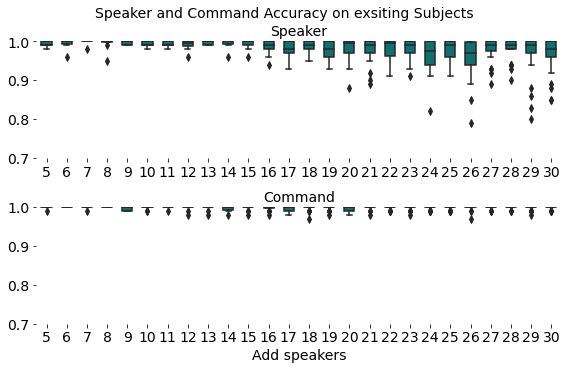

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
sns.boxplot(data=performance_speaker.transpose()[performance_speaker.transpose().iloc[2:,:]>0],width=0.5,color="teal")
plt.box(False)
plt.ylim([0.7,1.00])
plt.yticks(fontsize=14)
plt.xticks(range(len(performance_speaker)),performance_speaker["Subject_No"],fontsize=14)
plt.title("Speaker",fontsize=14)
plt.ylabel(None)
plt.subplot(2,1,2)
sns.boxplot(data=performance_command.transpose()[performance_speaker.transpose().iloc[2:,:]>0],width=0.5,color="teal")
plt.box(False)
plt.ylim([0.7,1.00])
plt.yticks(fontsize=14)
plt.xticks(range(len(performance_speaker)),performance_speaker["Subject_No"],fontsize=14)
plt.ylabel(None)
plt.title("Command",fontsize=14)
plt.xlabel("Add speakers",fontsize=14)
# fig.text(0.5, -0.05, 'Accuracy', ha='center', va='center', rotation='horizontal',fontsize=14)
fig.text(0.5, 1.0, 'Speaker and Command Accuracy on exsiting Subjects', ha='center', va='center', rotation='horizontal',fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
######################## 

In [17]:
performance_speaker.to_csv("performance_speaker_0531_5->30_final_free&unfree.csv",index=False)
performance_command.to_csv("performance_command_0531_5->30_final_free&unfree.csv",index=False)